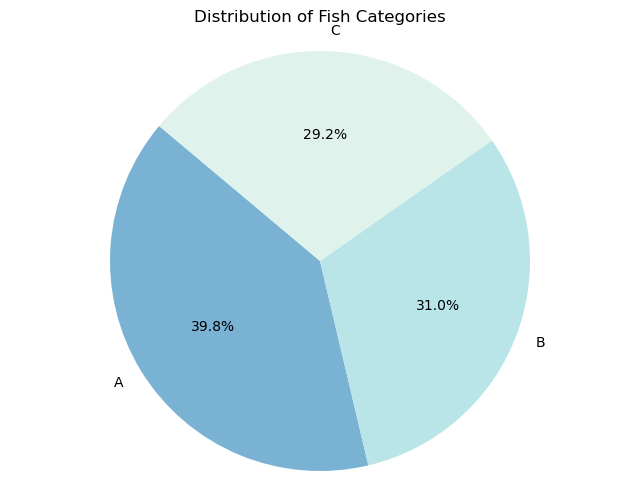

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_excel("SET.xlsx")
size_counts = data['Category'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(size_counts, labels=size_counts.index, autopct='%1.1f%%', startangle=140, colors = ['#7AB2D3', '#B9E5E8', '#DFF2EB'])
plt.title('Distribution of Fish Categories')
plt.axis('equal')
plt.show()

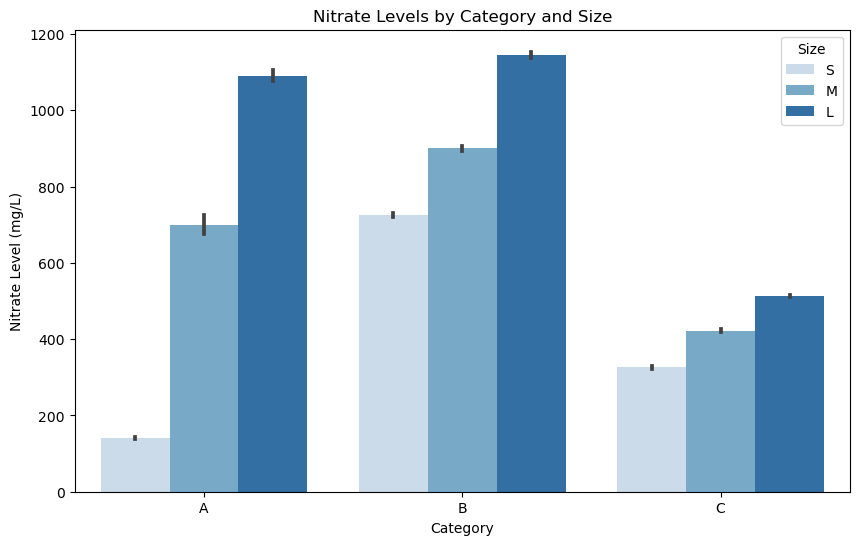

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_excel('SET.xlsx')
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Nitrate(mg/L)', hue='Size', data=data, palette='Blues')
plt.title('Nitrate Levels by Category and Size')
plt.xlabel('Category')
plt.ylabel('Nitrate Level (mg/L)')
plt.legend(title='Size')
plt.show()

In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor

data = pd.read_excel("SET.xlsx")
data['Category'] = data['Category'].map({'A': 0, 'B': 1, 'C': 2})
data['Size'] = data['Size'].map({'S': 0, 'M': 1, 'L': 2})

X = data[['Population', 'Category', 'Size', 'Fish_Length(cm)', 'Fish_Weight(g)', 'Nitrate(mg/L)']]
y = data[['Temperature (C)', 'Turbidity(NTU)', 'Dissolved Oxygen(mg/L)', 'PH', 'Ammonia(mg/L)']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dt_model = MultiOutputRegressor(DecisionTreeRegressor(random_state=42))
dt_model.fit(X_train_scaled, y_train)

y_pred_dt = dt_model.predict(X_test_scaled)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("Decision Tree Model Performance:")
print(f"Mean Squared Error: {mse_dt:.4f}")
print(f"Root Mean Squared Error: {rmse_dt:.4f}")
print(f"R² Score: {r2_dt:.4f}")

Decision Tree Model Performance:
Mean Squared Error: 24.8122
Root Mean Squared Error: 4.9812
R² Score: 0.7231


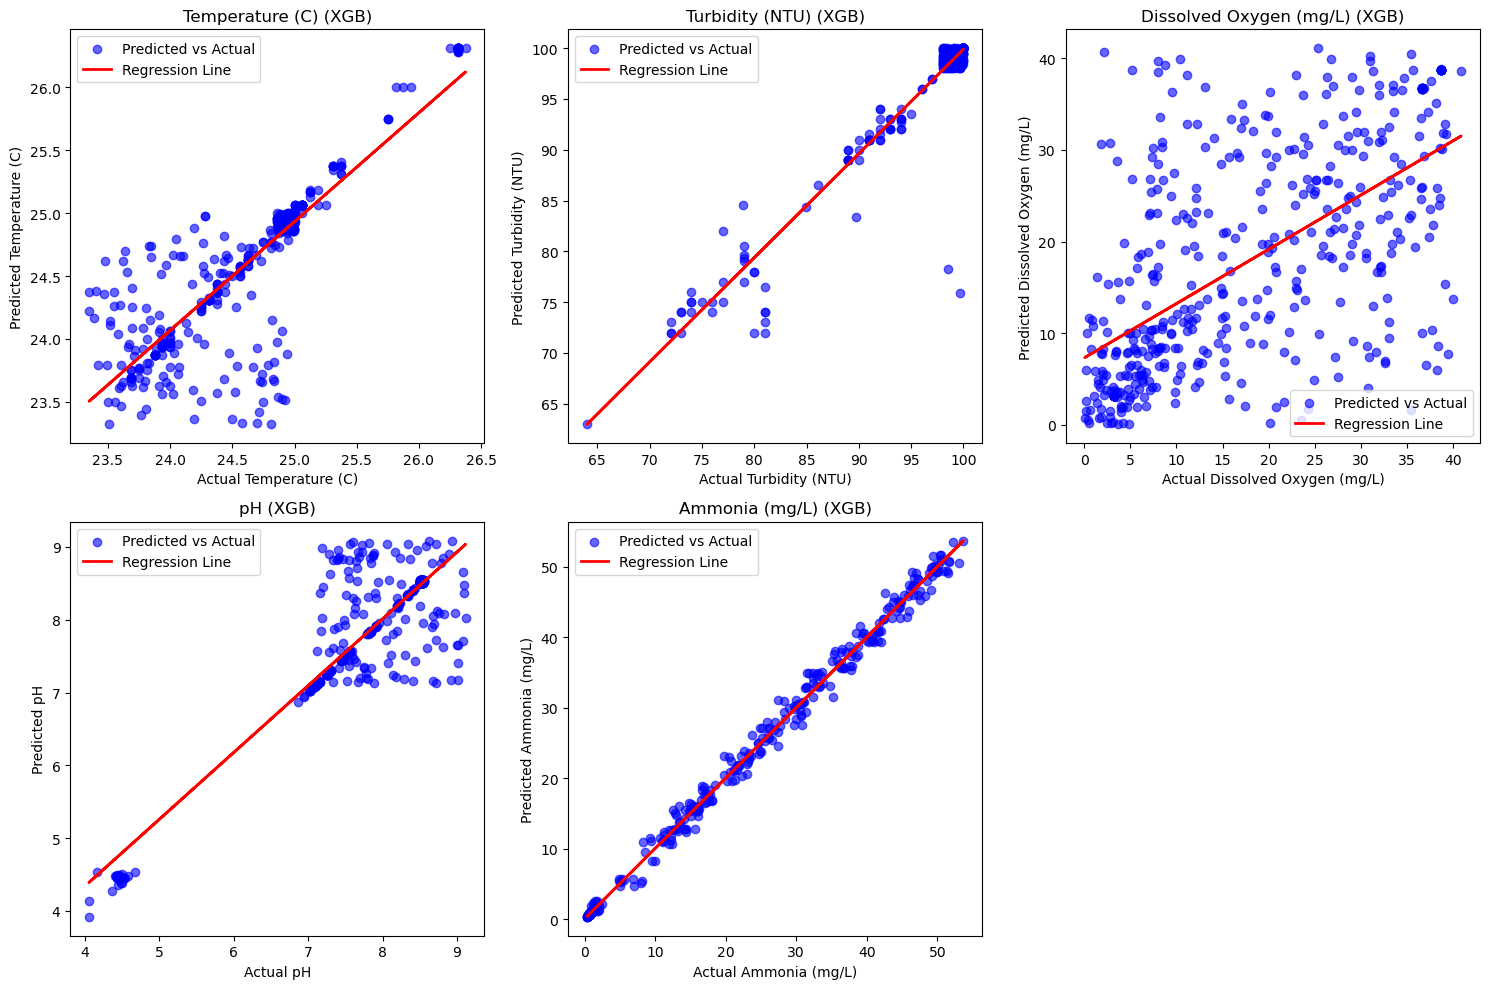

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_actual_vs_predicted_grid(y_test, y_pred, feature_names):
    num_features = len(feature_names)
    rows = 2
    cols = 3

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, len(feature_names))

    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()

    for i, feature in enumerate(feature_names):
        ax = axes[i]
        ax.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.6, color='blue', label='Predicted vs Actual')
        ax.set_xlabel(f'Actual {feature}')
        ax.set_ylabel(f'Predicted {feature}')
        ax.set_title(f'{feature} (XGB)')
        
        regression_line = np.polyfit(y_test.iloc[:, i], y_pred[:, i], 1)
        ax.plot(y_test.iloc[:, i], np.polyval(regression_line, y_test.iloc[:, i]), color='red', linewidth=2, label='Regression Line')
        ax.legend()

    for j in range(len(feature_names), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

output_features = ['Temperature (C)', 'Turbidity (NTU)', 'Dissolved Oxygen (mg/L)', 'pH', 'Ammonia (mg/L)']

plot_actual_vs_predicted_grid(y_test, y_pred_dt, output_features)

In [5]:
def predict_environmental_conditions_dt(model, scaler):
    population = int(input("Enter population: "))
    category = input("Enter category (A, B, or C): ").upper()
    size = input("Enter size (S, M, or L): ").upper()
    fish_length = float(input("Enter fish length (cm): "))
    fish_weight = float(input("Enter fish weight (g): "))
    nitrate_level = float(input("Enter nitrate level (mg/L): "))

    category_map = {'A': 0, 'B': 1, 'C': 2}
    size_map = {'S': 0, 'M': 1, 'L': 2}
    
    if category not in category_map or size not in size_map:
        raise ValueError("Invalid category or size. Please enter valid values.")
        
    category_encoded = category_map[category]
    size_encoded = size_map[size]
    
    feature_names = ['Population', 'Category', 'Size', 'Fish_Length(cm)', 'Fish_Weight(g)', 'Nitrate(mg/L)']
    input_data = pd.DataFrame(
        [[population, category_encoded, size_encoded, fish_length, fish_weight, nitrate_level]],
        columns=feature_names
    )
    
    input_data_scaled = scaler.transform(input_data)
    
    predicted_conditions = model.predict(input_data_scaled)

    if isinstance(model, MultiOutputRegressor):
        predicted_conditions = predicted_conditions[0]

    return {
        "Temperature (C)": predicted_conditions[0],
        "Turbidity (NTU)": predicted_conditions[1],
        "Dissolved Oxygen (mg/L)": predicted_conditions[2],
        "pH": predicted_conditions[3],
        "Ammonia (mg/L)": predicted_conditions[4]
    }

predictions = predict_environmental_conditions_dt(dt_model, scaler)

print("\nRecommended Environmental Conditions (Decision Tree):")
for key, value in predictions.items():
    print(f"{key}: {value:.2f}")
    
#26.3125	100	3.2	4.36175	1.00036	1100	50	33.24	320.45	A	L

Enter population: 50
Enter category (A, B, or C): A
Enter size (S, M, or L): L
Enter fish length (cm): 33.24
Enter fish weight (g): 320.45
Enter nitrate level (mg/L): 1100

Recommended Environmental Conditions (Decision Tree):
Temperature (C): 26.31
Turbidity (NTU): 100.00
Dissolved Oxygen (mg/L): 3.20
pH: 4.36
Ammonia (mg/L): 1.00


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

data = pd.read_excel("SET.xlsx")
data['Category'] = data['Category'].map({'A': 0, 'B': 1, 'C': 2})
data['Size'] = data['Size'].map({'S': 0, 'M': 1, 'L': 2})

X = data[['Population', 'Category', 'Size', 'Fish_Length(cm)', 'Fish_Weight(g)', 'Nitrate(mg/L)']]
y = data[['Temperature (C)', 'Turbidity(NTU)', 'Dissolved Oxygen(mg/L)', 'PH', 'Ammonia(mg/L)']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9063)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=250, random_state=9063))
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Model Performance:")
print(f"Mean Squared Error: {mse_rf:.4f}")
print(f"Root Mean Squared Error: {rmse_rf:.4f}")
print(f"R² Score: {r2_rf:.4f}")

Random Forest Model Performance:
Mean Squared Error: 22.7593
Root Mean Squared Error: 4.7707
R² Score: 0.7633


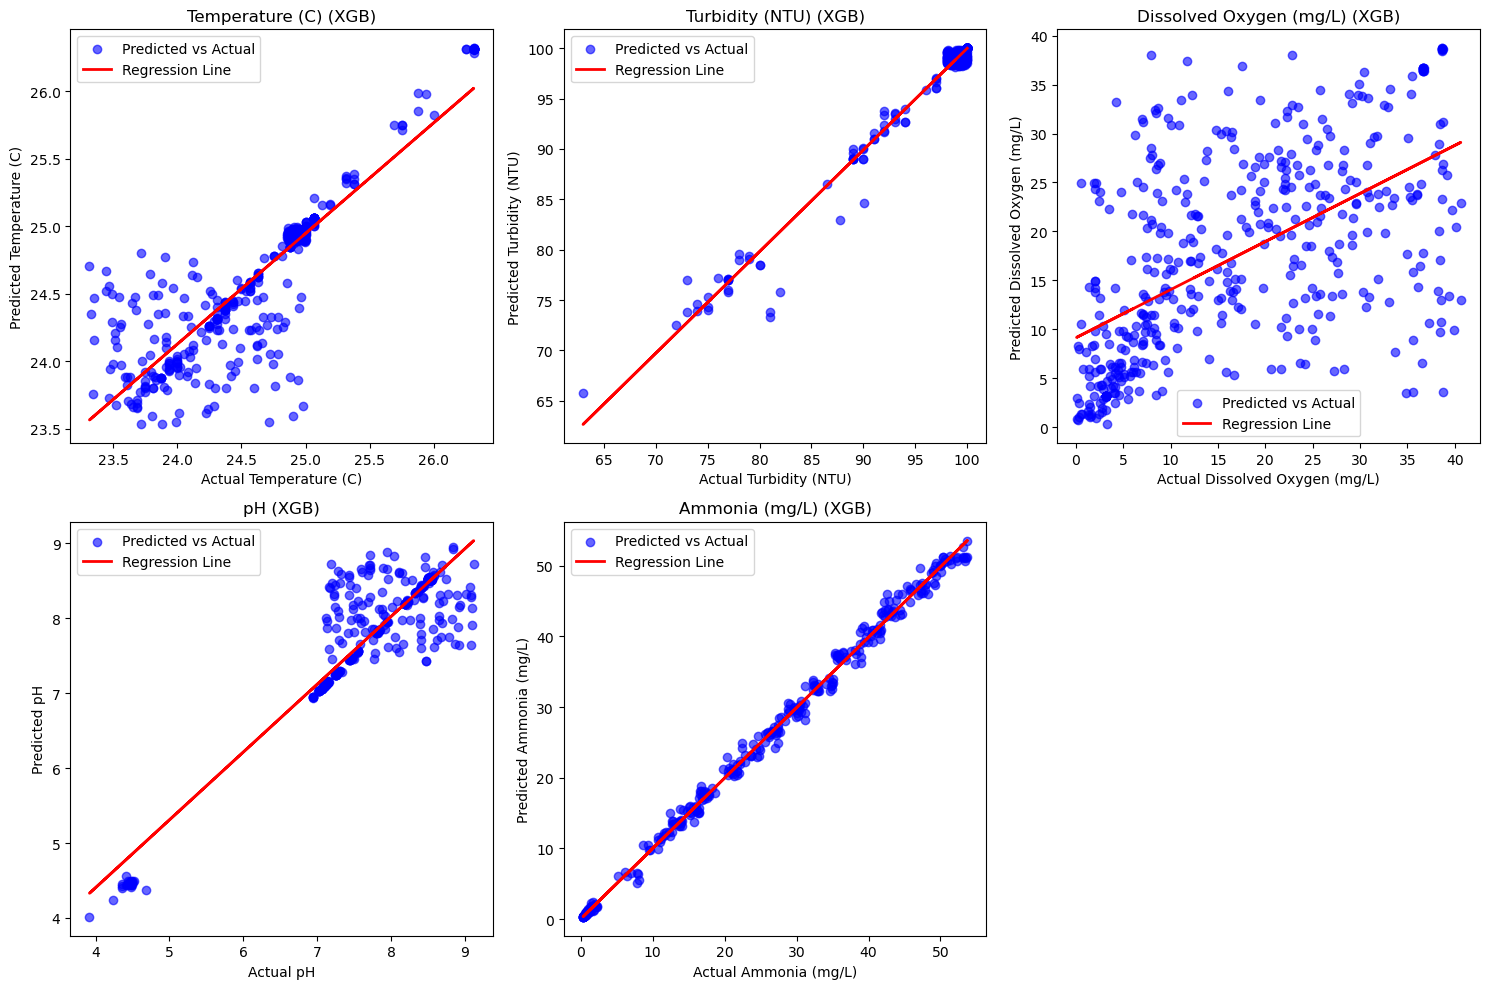

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_actual_vs_predicted_grid(y_test, y_pred, feature_names):
    num_features = len(feature_names)
    rows = 2
    cols = 3

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, len(feature_names))

    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()

    for i, feature in enumerate(feature_names):
        ax = axes[i]
        ax.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.6, color='blue', label='Predicted vs Actual')
        ax.set_xlabel(f'Actual {feature}')
        ax.set_ylabel(f'Predicted {feature}')
        ax.set_title(f'{feature} (XGB)')
        
        regression_line = np.polyfit(y_test.iloc[:, i], y_pred[:, i], 1)
        ax.plot(y_test.iloc[:, i], np.polyval(regression_line, y_test.iloc[:, i]), color='red', linewidth=2, label='Regression Line')
        ax.legend()

    for j in range(len(feature_names), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

output_features = ['Temperature (C)', 'Turbidity (NTU)', 'Dissolved Oxygen (mg/L)', 'pH', 'Ammonia (mg/L)']

plot_actual_vs_predicted_grid(y_test, y_pred_rf, output_features)

In [8]:
def predict_environmental_conditions_rf(model, scaler):
    population = int(input("Enter population: "))
    category = input("Enter category (A, B, or C): ").upper()
    size = input("Enter size (S, M, or L): ").upper()
    fish_length = float(input("Enter fish length (cm): "))
    fish_weight = float(input("Enter fish weight (g): "))
    nitrate_level = float(input("Enter nitrate level (mg/L): "))

    category_map = {'A': 0, 'B': 1, 'C': 2}
    size_map = {'S': 0, 'M': 1, 'L': 2}

    category_encoded = category_map[category]
    size_encoded = size_map[size]

    feature_names = ['Population', 'Category', 'Size', 'Fish_Length(cm)', 'Fish_Weight(g)', 'Nitrate(mg/L)']
    input_data = pd.DataFrame(
        [[population, category_encoded, size_encoded, fish_length, fish_weight, nitrate_level]],
        columns=feature_names
    )

    input_data_scaled = scaler.transform(input_data)

    predicted_conditions = model.predict(input_data_scaled)

    return {
        "Temperature (C)": predicted_conditions[0][0],
        "Turbidity (NTU)": predicted_conditions[0][1],
        "Dissolved Oxygen (mg/L)": predicted_conditions[0][2],
        "pH": predicted_conditions[0][3],
        "Ammonia (mg/L)": predicted_conditions[0][4]
    }

predictions = predict_environmental_conditions_rf(rf_model, scaler)

print("\nRecommended Environmental Conditions (Random Forest):")
for key, value in predictions.items():
    print(f"{key}: {value:.2f}")
    
#24.87525695	100	25.42495793	8.521656782	28.0886918	909	75	19.46	73.1	B	M

Enter population: 75
Enter category (A, B, or C): B
Enter size (S, M, or L): M
Enter fish length (cm): 19.46
Enter fish weight (g): 73.1
Enter nitrate level (mg/L): 909

Recommended Environmental Conditions (Random Forest):
Temperature (C): 24.91
Turbidity (NTU): 98.73
Dissolved Oxygen (mg/L): 22.69
pH: 8.51
Ammonia (mg/L): 26.22


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

data = pd.read_excel("SET.xlsx")
data['Category'] = data['Category'].map({'A': 0, 'B': 1, 'C': 2})
data['Size'] = data['Size'].map({'S': 0, 'M': 1, 'L': 2})

X = data[['Population', 'Category', 'Size', 'Fish_Length(cm)', 'Fish_Weight(g)', 'Nitrate(mg/L)']]
y = data[['Temperature (C)', 'Turbidity(NTU)', 'Dissolved Oxygen(mg/L)', 'PH', 'Ammonia(mg/L)']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9316)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=58160)
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Model Performance:")
print(f"Mean Squared Error: {mse_xgb:.4f}")
print(f"Root Mean Squared Error: {rmse_xgb:.4f}")
print(f"R² Score: {r2_xgb:.4f}")

XGBoost Model Performance:
Mean Squared Error: 14.9467
Root Mean Squared Error: 3.8661
R² Score: 0.8502


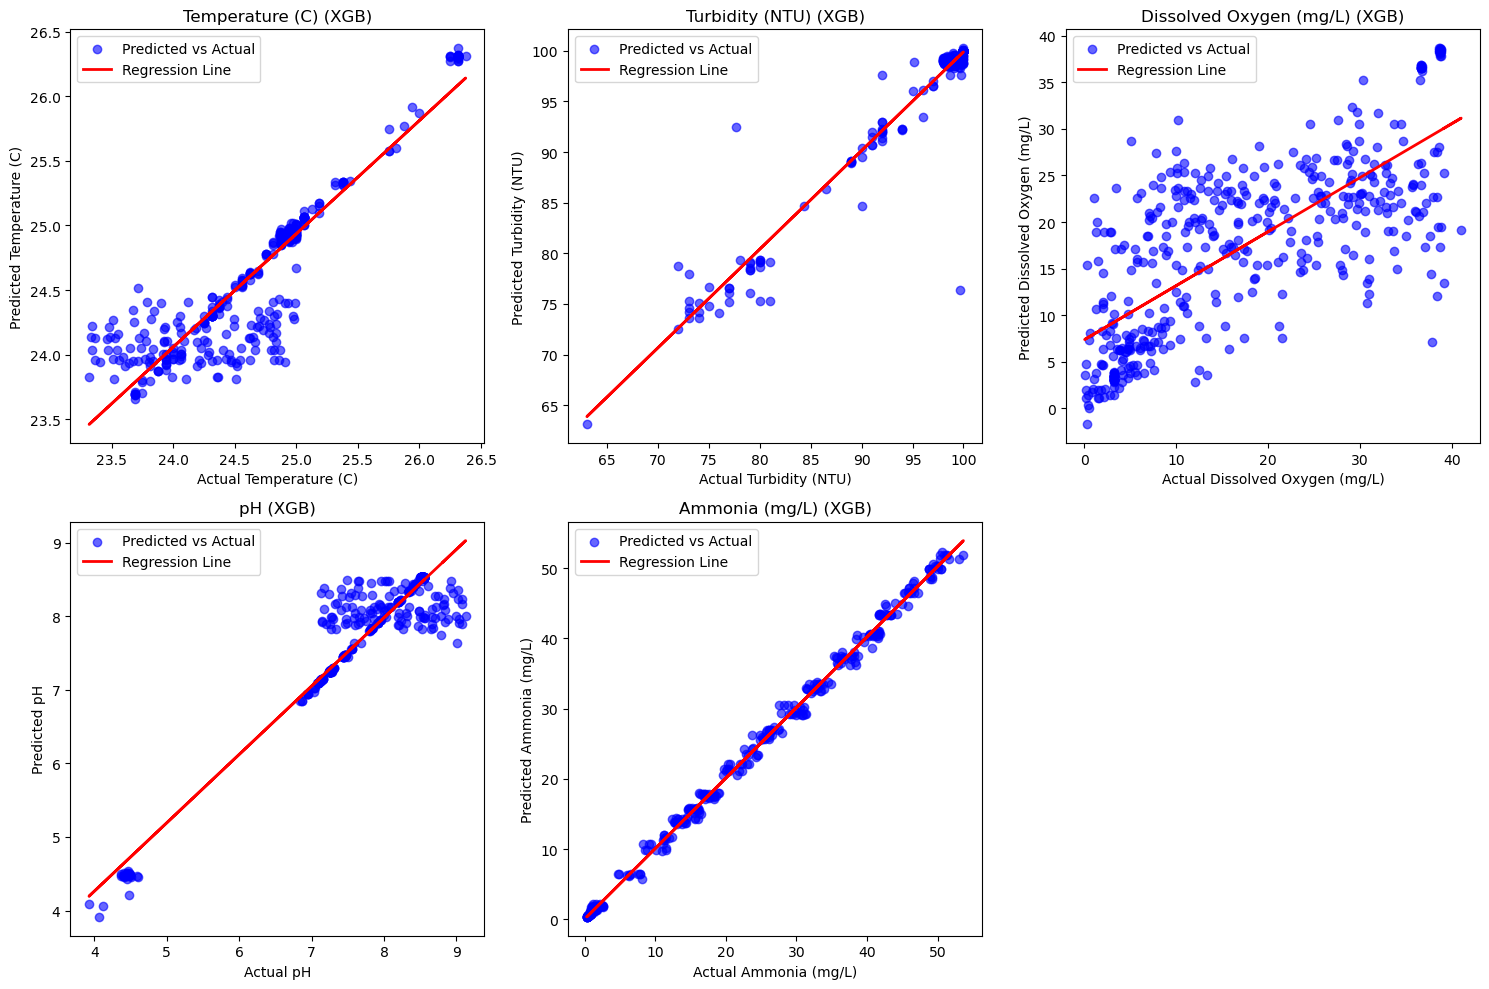

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_actual_vs_predicted_grid(y_test, y_pred, feature_names):
    num_features = len(feature_names)
    rows = 2
    cols = 3

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, len(feature_names))

    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()

    for i, feature in enumerate(feature_names):
        ax = axes[i]
        ax.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.6, color='blue', label='Predicted vs Actual')
        ax.set_xlabel(f'Actual {feature}')
        ax.set_ylabel(f'Predicted {feature}')
        ax.set_title(f'{feature} (XGB)')
        
        regression_line = np.polyfit(y_test.iloc[:, i], y_pred[:, i], 1)
        ax.plot(y_test.iloc[:, i], np.polyval(regression_line, y_test.iloc[:, i]), color='red', linewidth=2, label='Regression Line')
        ax.legend()

    for j in range(len(feature_names), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

output_features = ['Temperature (C)', 'Turbidity (NTU)', 'Dissolved Oxygen (mg/L)', 'pH', 'Ammonia (mg/L)']

plot_actual_vs_predicted_grid(y_test, y_pred_xgb, output_features)

In [17]:
def predict_environmental_conditions_xgb(model, scaler):
    population = float(input("Enter Population: "))
    category = input("Enter Category (A/B/C): ").strip().upper()
    size = input("Enter Size (S/M/L): ").strip().upper()
    fish_length = float(input("Enter Fish Length (cm): "))
    fish_weight = float(input("Enter Fish Weight (g): "))
    nitrate_level = float(input("Enter Nitrate Level (mg/L): "))

    category_map = {'A': 0, 'B': 1, 'C': 2}
    size_map = {'S': 0, 'M': 1, 'L': 2}

    category_encoded = category_map[category]
    size_encoded = size_map[size]

    feature_names = ['Population', 'Category', 'Size', 'Fish_Length(cm)', 'Fish_Weight(g)', 'Nitrate(mg/L)']
    input_data = pd.DataFrame(
        [[population, category_encoded, size_encoded, fish_length, fish_weight, nitrate_level]],
        columns=feature_names
    )

    input_data_scaled = scaler.transform(input_data)

    predicted_conditions = model.predict(input_data_scaled)

    return {
        "Temperature (C)": predicted_conditions[0][0],
        "Turbidity (NTU)": predicted_conditions[0][1],
        "Dissolved Oxygen (mg/L)": predicted_conditions[0][2],
        "pH": predicted_conditions[0][3],
        "Ammonia (mg/L)": predicted_conditions[0][4]
    }

predictions = predict_environmental_conditions_xgb(xgb_model, scaler)

print("\nRecommended Environmental Conditions (XGBoost):")
for key, value in predictions.items():
    print(f"{key}: {value:.2f}")
    
#24.87480289	99	31.12043703	8.519841242	50.91882442	1223	75	35.12	195.2	B	L

Enter Population: 75
Enter Category (A/B/C): B
Enter Size (S/M/L): L
Enter Fish Length (cm): 35.12
Enter Fish Weight (g): 195.2
Enter Nitrate Level (mg/L): 1223

Recommended Environmental Conditions (XGBoost):
Temperature (C): 24.94
Turbidity (NTU): 99.02
Dissolved Oxygen (mg/L): 20.93
pH: 8.53
Ammonia (mg/L): 50.35
